## Constraining Models of Massive Gravity Using the NANOGrav 15-Year Data Set

To reproduce our code, we start with importing all of the relevant python packages. We will import as we need them. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint

### Fig. 1

We generate Fig. 1 from the paper. 

We first define variables and functions we will be using.

In [6]:
# Define the parameters
H_inf = 1
a_r = 1 
tau_r = 1/(a_r*H_inf)
tau_r = 1/(a_r*H_inf)
k = 1
tau_m = 6*tau_r  # tau_m will be before matter-rad equality, but after inflation ends https://arxiv.org/pdf/1808.02381.pdf
tau_end = 3*tau_m
m = .8*H_inf
nu = np.sqrt(9/4 - m**2 / H_inf**2)
N = 5000
tau_init = -200*tau_r # the value that we start the plot at
tau = np.linspace(tau_init, tau_end, N)
N_neg_r = 0
N_pos_r = 0
N_m = 0
isReal = False                            

for val in tau:
    if val <= -tau_r:
        N_neg_r += 1
    if val <= tau_r:
        N_pos_r += 1
    if val <= tau_m:
        N_m += 1

def scale_fac(conf_time):
    if conf_time < tau_r:
        return -1/(H_inf*conf_time)
    else:
        return a_r * conf_time / tau_r


def d_scale_fac_dz(conf_time):
    if conf_time < tau_r:
        return -2/(H_inf*conf_time**3)
    else:
        return 0


def mu(conf_time):
    if conf_time < tau_m:
        return m
    else:
        return 0


# The input for the homogeneous version of EoM: chi''(u) + 2/u chi'(u) + chi(u) = 0
def M_derivs_homo(M, u):
    return [M[1], -(k**2 + (scale_fac(u)*mu(u))**2 - d_scale_fac_dz(u) / scale_fac(u)) * M[0]]

/home/user/Documents/mambaforge/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:242: ComplexWarning: Casting complex values to real discards the imaginary part
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


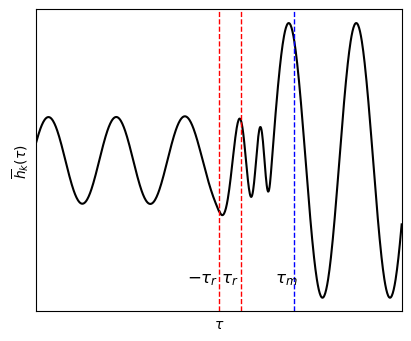

In [7]:
fig, (ax1) = plt.subplots(1, figsize=(4, 3.3),constrained_layout = True)


# We use the central difference method
xxx = np.array([tau[0] - 0.0000001, tau[0] + 0.0000001])
xx = (np.sqrt(-np.pi*xxx) / 2 * scipy.special.hankel1(nu, -k*xxx))[:2]
xx = xx[1] - xx[0]
xx /= xxx[1] - xxx[0]

# Get the homogeneous solution using scipy.integrate.odeint, and we case on whether it is real or imaginary
if isReal:
    v_0 = np.sqrt(-np.pi*tau[0]) / 2 * \
        scipy.special.hankel1(nu, -k*tau[0])
    v_prime_0 = xx
else:
    v_0 = np.sqrt(-np.pi*tau[0]) / 2 * \
        scipy.special.hankel1(nu, -k*tau[0]).imag
    v_prime_0 = xx.imag


v, v_prime = odeint(M_derivs_homo, [v_0, v_prime_0], tau[0:N_neg_r]).T


ax1.plot(
    tau[0:N_neg_r], v, label=r"Numerical solution", color="black"
)

v_0_rest = v[N_neg_r-1]
xxxxx = np.array([tau[N_neg_r-1] - 0.0000001, tau[N_neg_r-1] + 0.0000001])
if isReal:
    xxxx = (np.sqrt(-np.pi*xxxxx) / 2 *
            scipy.special.hankel1(nu, -k*xxxxx))[:2]
else:
    xxxx = -1j*(np.sqrt(-np.pi*xxxxx) / 2 *
                scipy.special.hankel1(nu, -k*xxxxx))[:2]
xxxx = xxxx[1] - xxxx[0]
xxxx /= xxxxx[1] - xxxxx[0]
v_prime_0_rest = xxxx
v_rest, v_prime_rest = odeint(
    M_derivs_homo, [v_0_rest, v_prime_0_rest], tau[N_pos_r:]).T

gap_len = tau[N_pos_r] - tau[N_neg_r]

ax1.plot(
    tau[N_pos_r:] - gap_len, v_rest, color="black"
)

ax1.set_xlabel(r"$\tau$")

ax1.set_xlim(-tau_end, tau_end - gap_len)
ax1.set_ylabel(r"$\overline{h}_k(\tau)$")

epsilon = .0001

plt.axvline(x=-tau_r, color='red', linestyle='dashed',
            linewidth=1)
plt.axvline(x=tau_r, color='red', linestyle='dashed',
            linewidth=1, label=r'$\pm \tau_r$')
plt.axvline(x=tau_m, color='blue', linestyle='dashed',
            linewidth=1, label=r'$\tau_m$')
plt.text(-tau_r-3, -2, r'$-\tau_r$',size=12)
plt.text(-tau_r+.2, -2, r'$\tau_r$', size=12)
plt.text(tau_m+.2- gap_len, -2, r'$\tau_m$',size=12)

plt.xticks([])
plt.yticks([])

plt.legend().set_visible(False)
plt.savefig("figs/fig1.pdf")
plt.show()


### Fig. 2 

In order to generate figure 2, which consists of three 2-d plots, we import some more packages and define some more variables and functions. 

In [11]:
import matplotlib.ticker as mticker
import math

import enterprise.constants as const
import h5py
import json
from math import log10, floor

In [17]:
T = 6.58e-25
L = 1.97e-16
m2Gpc = 3.1e25

c_g = 1 
hbar = 6.582119569e-25  # GeV / Hz
c = 3e8 # m / s
omega_M = .3111
omega_R = 9.182e-5
omega_L = .6889

h = .6766 # according to Planck 2018 TT, TE, EE + lowE + lensing + BAO data
H_0 = 100*h*3.2404407e-20 # in Hz 
M_GW = H_0*1e10
a_0 = 1.

eta_0 = np.sqrt(4/(H_0**2*omega_M))
tau_r = 5.494456683825391e-7  # calculated from equation (19)
f_yr = 1/(365*24*3600)

def hz2gpc(hz): 
    return hz*(T/L)*m2Gpc
def gpc2hz(gpc): 
    return gpc*(1/m2Gpc)*L/T

def P_T_prim(k):
    n_T = 0
    # from page 3 of https://arxiv.org/pdf/1407.4785.pdf
    k_ref = gpc2hz(0.01*1e3)
    r = .2
    P_gamma_k_ref = 2.2e-9  # also from same page in same paper
    A_T_at_k_ref = r*P_gamma_k_ref
    return A_T_at_k_ref*(k/k_ref)**n_T


def T_1_sq(x):
    return 1+1.57*x+3.42*x**2


def T_2_sq(x):
    return 1/(1-.22*x**1.5+.65*x**2)


def T_3_sq(x):
    return 1+.59*x+.65*x**2


def g_star_T_in(k, g_0):
    g_max = 106.75
    A = (-1 - 10.75/g_0)/(-1+10.75/g_0)
    B = (-1 - g_max/10.75)/(-1+g_max/10.75)
    return g_0*((A+np.tanh(-2.5*np.log10(k/(2*np.pi)/(2.5e-12))))/(A+1))*((B+np.tanh(-2.0*np.log10(k/(2*np.pi)/(6e-9))))/(B+1))


def spherical_bess_approx(n, x):
    return 1/(np.sqrt(2)*x)


def T_T_sq(k):
    g_star_0 = 3.36
    g_star_s_0 = 3.91
    tau_0 = eta_0/1e-3
    T_R = 1e12  # in GeV
    T_R = 1e14
    k_mpc = hz2gpc(k)/1e3
    k_eq = 7.1e-2*omega_M*h**2
    g_star_T_R = 106.75*g_star_s_0/g_star_0
    k_R = 1.7e14*(g_star_T_R/106.75)**(1/6)*(T_R/1e7)
    x_eq = k_mpc/k_eq
    x_R = k_mpc/k_R
    func_to_use = spherical_bess_approx
    norm = 25
    return omega_M**2*(g_star_T_in(k, g_star_0)/g_star_0)*(g_star_s_0/g_star_T_in(k, g_star_s_0))**(4/3)*(3*(func_to_use(1, k*tau_0))/(k*tau_0))**2*T_1_sq(x_eq)*T_2_sq(x_R)*norm


def P_T(k):
    return T_T_sq(k)*P_T_prim(k)


def omega_GW_massless(k):
    return 1/12*(k/(a_0*H_0))**2*P_T(k)


def omega_GW_full(f, m, hinf, tr, tm):
    nu = (9/4 - m**2 / hinf**2)**.5
    k = f*2*np.pi
    return tm/tr*(k*tr)**(3-2*nu)*omega_GW_massless(k)


def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

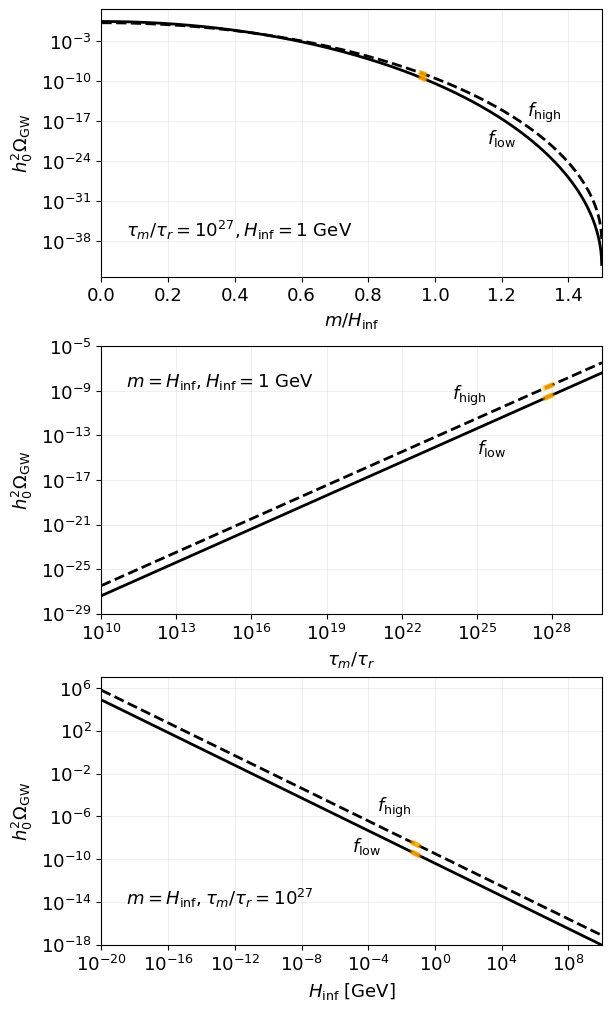

In [18]:
fs = 13
plt.rcParams.update({'font.size': fs})

# Much of this code is taken from the NANOGrav collaboration's github page, where they have code that generates certain plots from their set of 4 (or 5?) papers.
hdf_file = "data/15yr_quickCW_detection.h5"

# specify how much of the first samples to discard
burnin = 0
extra_thin = 1
with h5py.File(hdf_file, 'r') as f:
    samples_cold = f['samples_cold'][0, burnin::extra_thin, :]


N = 1000
f = np.linspace(-9, math.log(3e-7, 10), N)
f = np.logspace(-8.6, -7, 30)
freqs_30 = f

def omega_GW(f, A_cp, gamma):
    return 2*np.pi**2*(10**A_cp)**2*f_yr**2/(3*H_0**2)*(f/f_yr)**(5-gamma)


dir = '30f_fs{hd}_ceffyl'
freqs = np.load('data/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/' + dir + '/freqs.npy')
num_freqs = 30

A_arr = samples_cold[:, -1]
gamma_arr = samples_cold[:, -2]
OMG_15 = np.zeros((67, num_freqs))

freqs_boundary = [freqs[0], freqs[-1]]

Omega_sig_f_low = []
Omega_sig_f_high = []   

for ii in range(67):
    OMG_15[ii] = np.log10(h**2*omega_GW(freqs, A_arr[ii], gamma_arr[ii]))

Omega_sig_f_low += [10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0))[0], 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0))[0]]
Omega_sig_f_low += [10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0))[0], 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0))[0]]
Omega_sig_f_low += [10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0))[0], 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0))[0]]

Omega_sig_f_high += [10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0))[-1], 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0))[-1]]
Omega_sig_f_high += [10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0))[-1], 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0))[-1]]
Omega_sig_f_high += [10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0))[-1], 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0))[-1]]

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(6,10),constrained_layout = True)

 
N = 2000
num_freqs = N
H_inf = 1  # in GeV
tau_r = 5.494456683825391e-7  # calculated from equation (19)
a_r = 1/(tau_r*H_inf)

f_UV = 1/tau_r / (2*np.pi)
tau_m = 1e27*tau_r

freqs = np.logspace(-19,np.log10(f_UV),num_freqs)

M_arr = np.linspace(0.00000001, 1.499999, N)
colors = ['black', 'black']
lw = 2
thicker = 1.5

omega_arr = [omega_GW_full(freqs_boundary[0], M_arr*H_inf, H_inf, tau_r, tau_m), omega_GW_full(freqs_boundary[1], M_arr*H_inf, H_inf, tau_r, tau_m)]
last_idx = len(omega_arr[0])-1
partition_idx_low = [last_idx,last_idx,last_idx,last_idx,last_idx,last_idx]
partition_idx_high = [last_idx,last_idx,last_idx,last_idx,last_idx,last_idx]
i = last_idx
while i >= 0:
    for j in range(6):
        if omega_arr[0][i] <= Omega_sig_f_low[j]:
            partition_idx_low[j] -= 1
        if omega_arr[1][i] <= Omega_sig_f_high[j]:
            partition_idx_high[j] -= 1
    i-=1

ax1.plot(M_arr, omega_arr[0], color = colors[0], linewidth = lw)
ax1.plot(M_arr, omega_arr[1], color = colors[1], linewidth = lw, linestyle='dashed')

for i in range(3):
    ax1.plot(M_arr[partition_idx_low[2*i+1]:partition_idx_low[2*i]], omega_arr[0][partition_idx_low[2*i+1]:partition_idx_low[2*i]] , color = 'orange', alpha = 0.7-i*0.2, linewidth = lw+thicker)
    ax1.plot(M_arr[partition_idx_low[2*i+1]:partition_idx_low[2*i]], omega_arr[1][partition_idx_low[2*i+1]:partition_idx_low[2*i]] , color = 'orange', alpha = 0.7-i*0.2, linewidth = lw+thicker)

ax1.set_yscale('log')
ax1.set_xlabel(r'$m/H_{\mathrm{inf}}$')
ax1.set_xlim(0,1.5)

ax1.annotate(r'$\tau_m/\tau_r = 10^{27}, H_{\mathrm{inf}} = 1$ GeV', xy=(0.05,0.15),xycoords='axes fraction',fontsize=fs)
ax1.annotate(r'$f_{\mathrm{low}}$', xy=(0.77,0.5),xycoords='axes fraction',fontsize=fs)
ax1.annotate(r'$f_{\mathrm{high}}$', xy=(0.85,0.60),xycoords='axes fraction',fontsize=fs)

tau_m_arr = np.logspace(5,31, N)
M_GW = H_inf

omega_arr = [omega_GW_full(freqs_boundary[0],  M_GW, H_inf, tau_r, tau_m_arr*tau_r), omega_GW_full(freqs_boundary[1], M_GW, H_inf, tau_r, tau_m_arr*tau_r)]
partition_idx_low = [0,0,0,0,0,0]
partition_idx_high = [0,0,0,0,0,0]
for i in range(len(omega_arr[0])):
    for j in range(6):
        if omega_arr[0][i] <= Omega_sig_f_low[j]:
            partition_idx_low[j] += 1
        if omega_arr[1][i] <= Omega_sig_f_high[j]:
            partition_idx_high[j] += 1
ax2.plot(tau_m_arr, omega_GW_full(freqs_boundary[0], M_GW, H_inf, tau_r, tau_m_arr*tau_r), color = colors[0], linewidth = lw)
ax2.plot(tau_m_arr, omega_GW_full(freqs_boundary[1], M_GW, H_inf, tau_r, tau_m_arr*tau_r), color = colors[1], linewidth = lw, linestyle='dashed')

for i in range(3):
    ax2.plot(tau_m_arr[partition_idx_low[2*i]:partition_idx_low[2*i+1]], omega_arr[0][partition_idx_low[2*i]:partition_idx_low[2*i+1]] , color = 'orange', alpha = 0.7-i*0.2, linewidth = lw+thicker)
    ax2.plot(tau_m_arr[partition_idx_low[2*i]:partition_idx_low[2*i+1]], omega_arr[1][partition_idx_low[2*i]:partition_idx_low[2*i+1]] , color = 'orange', alpha = 0.7-i*0.2, linewidth = lw+thicker)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$\tau_m / \tau_r$')
ax2.set_xlim(1e10,1e30)
ax2.set_ylim(1e-29,1e-5)

ax2.annotate(r'$m = H_{\mathrm{inf}}, H_{\mathrm{inf}} = 1$ GeV', xy=(0.05,0.85),xycoords='axes fraction',fontsize=fs)
ax2.annotate(r'$f_{\mathrm{low}}$', xy=(0.75,0.6),xycoords='axes fraction',fontsize=fs)
ax2.annotate(r'$f_{\mathrm{high}}$', xy=(0.7,0.8),xycoords='axes fraction',fontsize=fs)

H_inf = np.logspace(-24, 14, N) # in GeV

tau_r = 1/(a_r*H_inf)

tau_m = 1e27*tau_r 
M_GW = H_inf

omega_arr = [omega_GW_full(freqs_boundary[0],  M_GW, H_inf, tau_r, tau_m), omega_GW_full(freqs_boundary[1], M_GW, H_inf, tau_r, tau_m)]
partition_idx_low = [last_idx,last_idx,last_idx,last_idx,last_idx,last_idx]
partition_idx_high = [last_idx,last_idx,last_idx,last_idx,last_idx,last_idx]
i = last_idx
while i >= 0:
    for j in range(6):
        if omega_arr[0][i] <= Omega_sig_f_low[j]:
            partition_idx_low[j] -= 1
        if omega_arr[1][i] <= Omega_sig_f_high[j]:
            partition_idx_high[j] -= 1
    i-=1

ax3.plot(H_inf, omega_GW_full(freqs_boundary[0], M_GW, H_inf, tau_r, tau_m), color = colors[0], linewidth = lw)
ax3.plot(H_inf, omega_GW_full(freqs_boundary[1], M_GW, H_inf, tau_r, tau_m), color = colors[1], linewidth = lw, linestyle='dashed')

for i in range(3):
    ax3.plot(H_inf[partition_idx_low[2*i+1]:partition_idx_low[2*i]], omega_arr[0][partition_idx_low[2*i+1]:partition_idx_low[2*i]] , color = 'orange', alpha = 0.7-i*0.2, linewidth = lw+thicker)   
    ax3.plot(H_inf  [partition_idx_low[2*i+1]:partition_idx_low[2*i]], omega_arr[1][partition_idx_low[2*i+1]:partition_idx_low[2*i]] , color = 'orange', alpha = 0.7-i*0.2, linewidth = lw+thicker)


ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$H_{\mathrm{inf}}$ [GeV]')
ax3.set_xlim(1e-20,1e10)
ax3.set_ylim(1e-18,1e7)

ax3.annotate(r'$m = H_{\mathrm{inf}}, \tau_m/\tau_r = 10^{27}$', xy=(0.05,0.15),xycoords='axes fraction',fontsize=fs)
ax3.annotate(r'$f_{\mathrm{low}}$', xy=(0.5,0.35),xycoords='axes fraction',fontsize=fs)
ax3.annotate(r'$f_{\mathrm{high}}$', xy=(0.55,0.5),xycoords='axes fraction',fontsize=fs)

axs = [ax1,ax2,ax3]

for i in range(3):
    axs[i].set_ylabel(r'$h_0^2\Omega_{\mathrm{GW}}$')
    axs[i].grid(which='major', alpha=.2)
    axs[i].grid(which='minor', alpha=.2)
    
plt.savefig('figs/fig2.pdf')
plt.show()

### Fig. 3

We now use the data from the NANOGrav 15-year data set in order to plot the following figures.  

In [19]:
fs = 11.5
plt.rcParams.update({'font.size': fs})

f_yr = 1/(365*24*3600)
gamma_cp = 3.2  # from page 4 of https://iopscience.iop.org/article/10.3847/2041-8213/acdac6/pdf
A_cp = -14.19382002601611
f_BBN = 1.5e-11 # in Hz according to 22.290 of maggiore vol 2 
N = 1000
num_freqs = 30
BBN = h**2*1e-5

def powerlaw_vec(f, f_0, log10_A=A_cp, gamma=gamma_cp):
    return np.sqrt((10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma) * f_0)


def powerlaw(f, log10_A=A_cp, gamma=gamma_cp):
    return np.sqrt((10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma) * f[0])


def round_it(x, sig):
    if x == 0:
        return 0
    return round(x, sig-int(floor(log10(abs(x))))-1)

def omega_GW(f, A_cp, gamma):
    return 2*np.pi**2*(10**A_cp)**2*f_yr**2/(3*H_0**2)*(f/f_yr)**(5-gamma)

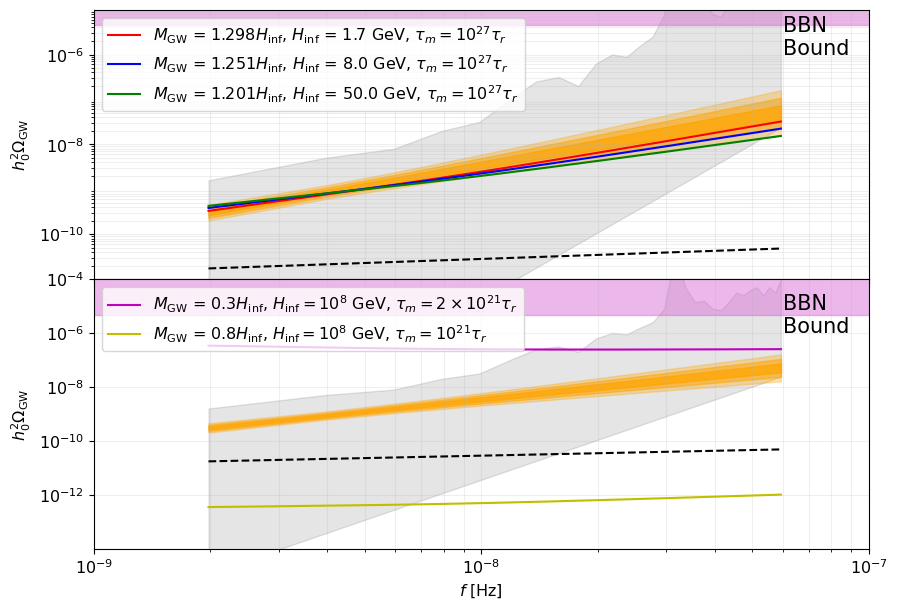

In [20]:
# You can download this yourself from the official NANOGrav release 
# https://zenodo.org/records/8067506/files/NANOGrav15yr_CW-Analysis_v1.0.0.zip
hdf_file = "data/15yr_quickCW_detection.h5"

# specify how much of the first samples to discard
burnin = 0
extra_thin = 1

with h5py.File(hdf_file, 'r') as f:
    samples_cold = f['samples_cold'][0, burnin::extra_thin, :]

# Make Figure
fig, axs = plt.subplots(2, 1, figsize = (10,7), sharex=True)
fig.subplots_adjust(hspace=0)

dir = '30f_fs{hd}_ceffyl'
freqs = np.load('data/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/' + dir + '/freqs.npy')
num_freqs = 30

A_arr = samples_cold[:, -1]
gamma_arr = samples_cold[:, -2]
OMG_15 = np.zeros((67, num_freqs))

slope = (14.8-7.5)/(np.log10(6e-8) - np.log10(2e-9))
b = -7.6 - slope*np.log10(6e-8)
lower = slope*np.log10(freqs) + b
lower = 10**lower

upper = np.array([-8.8, -8.3, -8.1, -7.7, -7.5, -7., -6.6, -6.5, -6.7, -6.2, -6, -6.05, -5.8, -5.6, -5.1, -3, -4.3, -4.85, -4.8, -5.1, -5.15, -4.85, -4.5, -4.6, -4.4, -4.3, -4.6, -4.3, -4.5, -4]) # Manually obtained from Fig. 3 of https://iopscience.iop.org/article/10.3847/2041-8213/acdc91/pdf
upper = 10**upper

for ii in range(67):
    OMG_15[ii] = np.log10(h**2*omega_GW(freqs, A_arr[ii], gamma_arr[ii]))
for i in range(2):
    axs[i].fill_between(freqs, lower, upper, color='black', alpha=0.1)
    axs[i].fill_between(freqs, 10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0)), color='orange', alpha=0.7)
    axs[i].fill_between(freqs, 10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0)), color='orange', alpha=0.5)
    axs[i].fill_between(freqs, 10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0)), color='orange', alpha=0.3)

    axs[i].plot(freqs,h**2*omega_GW(freqs, -15.6, 4.7),
            linestyle='dashed', color='black')

num_freqs = 1000
tau_r = 5.494456683825391e-7  # calculated from equation (19)

a_r = 1/(tau_r*1e8)

color_arr = ['red', 'blue', 'green','m', 'y']
H_inf_arr = [1.7, 8, 5e1, 1e8,1e8]
M_arr = [1.298, 1.251, 1.201, .3, .8]
H_inf_arr = np.array(H_inf_arr)
tau_r_arr = 1/(a_r*H_inf_arr)
tau_m_arr = np.array([1e27,1e27,1e27,2e21,1e21])*tau_r_arr
idx = 0
for M_GW in M_arr:
    H_inf = H_inf_arr[idx]
    M_GW *= H_inf
    tau_r = tau_r_arr[idx]
    freqs = np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num_freqs)
    tau_m = tau_m_arr[idx]
    Omega = np.where(h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m)< BBN, np.nan, BBN)
    if idx <= 2:
        axs[0].plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),color=color_arr[idx], label=r"$M_{\mathrm{GW}}$ = "+f'{M_arr[idx]}'+r'$H_{\mathrm{inf}}$' + r", $H_{\mathrm{inf}}$ = "+f'{H_inf} GeV' + r", $\tau_m = 10^{27}\tau_r$")
    elif idx == 3:
        axs[1].plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),color=color_arr[idx], label=r"$M_{\mathrm{GW}}$ = "+f'{M_arr[idx]}'+r'$H_{\mathrm{inf}}$' + r", $H_{\mathrm{inf}} = 10^8$ GeV" + r", $\tau_m = 2\times 10^{21}\tau_r$")
    else:
        axs[1].plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),color=color_arr[idx], label=r"$M_{\mathrm{GW}}$ = "+f'{M_arr[idx]}'+r'$H_{\mathrm{inf}}$' + r", $H_{\mathrm{inf}} = 10^8$ GeV" + r", $\tau_m = 10^{21}\tau_r$")
    idx+=1

BBN_f = np.logspace(np.log10(f_BBN), 9)
for i in range(2):
    axs[i].fill_between((BBN_f), (BBN_f*0+h**2*1e-5),
                    (BBN_f * 0 + 1e15), alpha=0.5, color='orchid')
    axs[i].text(6e-8, 1e-6, "BBN\nBound", fontsize=15)

outfile = np.load('data/nanograv_sens_full.npz')

freq_NG = []
omega_GW_NG = []
idx = 0
with open('data/sensitivity_curves_NG15yr_fullPTA.txt', 'r') as file:
    for line in file:
        if idx != 0:
            elems = line.strip("\r\n").split(",")
            freq_NG.append(float(elems[0]))
            omega_GW_NG.append(float(elems[3]))
        idx +=1

f_nanoGrav = outfile['freqs']
nanoGrav_sens = outfile['sens']
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'$h_0^2\Omega_{\mathrm{GW}}$')
    axs[i].grid(which='major', alpha=.2)
    axs[i].grid(which='minor', alpha=.2)
    axs[i].legend(loc='upper left')
axs[0].set_ylim(1e-11, 1e-5)
axs[1].set_ylim(1e-14, 1e-4)    
axs[0].set_yticks(np.array([1e-10,1e-8, 1e-6 ]))
axs[1].set_yticks(np.array([1e-12,1e-10,1e-8,1e-6,1e-4]))

plt.xlabel(r'$f$ [Hz]')
plt.xlim(1e-9,1e-7)
plt.savefig('figs/fig3.pdf')
plt.show()

### Fig. 4 

We plot figure 4, a plot with the full frequency range of the energy densities we just plotted, with a zoomed in region. 

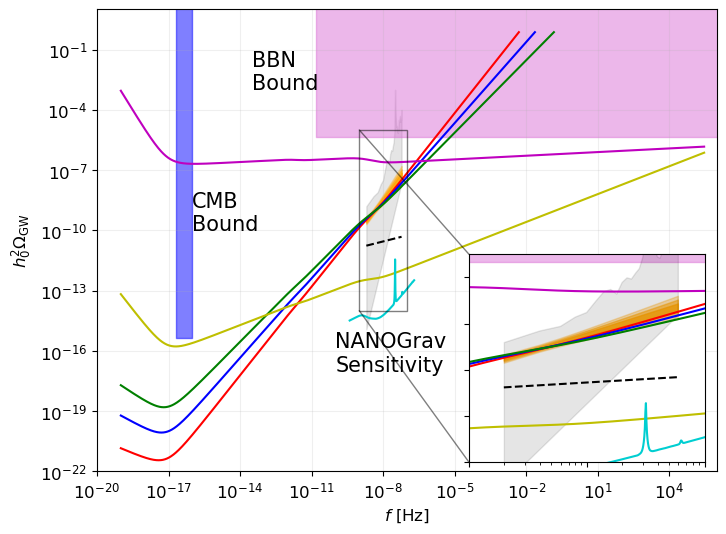

In [21]:
fs = 12
plt.rcParams.update({'font.size': fs})

fig, ax = plt.subplots(1, 1, figsize = (8,6))

N = 1000

CMB_f = np.logspace(-16.7, -16)
plt.fill_between(CMB_f,CMB_f*0+h**2*1e-15, CMB_f *
                 0 + 1e15, alpha=0.5, color='blue')
plt.text(1e-16, 1e-10, "CMB\nBound", fontsize=15)

dir = '30f_fs{hd}_ceffyl'
freqs_raw = np.load('data/NANOGrav15yr_KDE-FreeSpectra_v1.0.0/' + dir + '/freqs.npy')
freqs = freqs_raw
num_freqs = 30

slope = (14.8-7.5)/(np.log10(6e-8) - np.log10(2e-9))
b = -7.6 - slope*np.log10(6e-8)
lower = slope*np.log10(freqs) + b
lower = 10**lower

upper = np.array([-8.8, -8.3, -8.1, -7.7, -7.5, -7., -6.6, -6.5, -6.7, -6.2, -6, -6.05, -5.8, -5.6, -5.1, -3, -4.3, -4.85, -4.8, -5.1, -5.15, -4.85, -4.5, -4.6, -4.4, -4.3, -4.6, -4.3, -4.5, -4])
upper = 10**upper

plt.fill_between(freqs, lower, upper, color='black', alpha=0.1)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0)), color='orange', alpha=0.7)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0)), color='orange', alpha=0.5)
plt.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0)), color='orange', alpha=0.3)

plt.plot(freqs,h**2*omega_GW(freqs, -15.6, 4.7),
         linestyle='dashed', color='black')

num_freqs = 1000
tau_r = 5.494456683825391e-7  # calculated from equation (19)

a_r = 1/(tau_r*1e8)

color_arr = ['red', 'blue', 'green', 'm', 'y']

H_inf_arr = [1.7, 8, 5e1, 1e8,1e8]

M_arr = [1.298, 1.251, 1.201, .3, .8]
H_inf_arr = np.array(H_inf_arr)
tau_r_arr = 1/(a_r*H_inf_arr)
tau_m_arr = [1e10*(H_inf_arr[0]/1e14)**-2,1e10*(H_inf_arr[1]/1e14)**-2,1e10*(H_inf_arr[2]/1e14)**-2,1e21, 1e23] *tau_r_arr
tau_m_arr = np.array([1e27,1e27,1e27,2e21,1e21])*tau_r_arr
idx = 0
for M_GW in M_arr:
    H_inf = H_inf_arr[idx]
    M_GW *= H_inf
    tau_r = tau_r_arr[idx]
    f_UV = 1/tau_r / (2*np.pi)
    freqs = np.logspace(-19,np.log10(f_UV),num_freqs)
    tau_m = tau_m_arr[idx]
    Omega = np.where(h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m)< BBN, np.nan, BBN)
    plt.plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),color=color_arr[idx])
    idx+=1

plt.fill_between((BBN_f), (BBN_f*0+h**2*1e-5),
                 (BBN_f * 0 + 1e15), alpha=0.5, color='orchid')
plt.text(10**-13.5, 1e-3, "BBN\nBound", fontsize=15)

plt.plot(f_nanoGrav, nanoGrav_sens, color='darkturquoise')
plt.text(1e-10, 1e-17, "NANOGrav\nSensitivity", fontsize=15)

axins = ax.inset_axes([0.6, 0.02, 0.38, 0.45])
idx = 0
for M_GW in M_arr:
    H_inf = H_inf_arr[idx]
    M_GW *= H_inf
    tau_r = tau_r_arr[idx]
    f_UV = 1/tau_r / (2*np.pi)
    freqs = np.logspace(-19,np.log10(f_UV),num_freqs)
    tau_m = tau_m_arr[idx]
    Omega = np.where(h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m)< BBN, np.nan, BBN)
    axins.plot(freqs, h**2*omega_GW_full(freqs, M_GW, H_inf, tau_r, tau_m),color=color_arr[idx])
    idx+=1
axins.fill_between((BBN_f), (BBN_f*0+h**2*1e-5),
                 (BBN_f * 0 + 1e15), alpha=0.5, color='orchid')
axins.plot(f_nanoGrav, nanoGrav_sens, color='darkturquoise')
freqs = freqs_raw
axins.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 1*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 1*OMG_15.std(axis=0)), color='orange', alpha=0.7)
axins.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 2*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 2*OMG_15.std(axis=0)), color='orange', alpha=0.5)
axins.fill_between(freqs, 10**(OMG_15.mean(axis=0) - 3*OMG_15.std(axis=0)), 10**(OMG_15.mean(axis=0) + 3*OMG_15.std(axis=0)), color='orange', alpha=0.3)
axins.plot(freqs,h**2*omega_GW(freqs, -15.6, 4.7),
         linestyle='dashed', color='black')
axins.fill_between(freqs, lower, upper, color='black', alpha=0.1)
axins.set_xscale('log')
axins.set_yscale('log')

x1, x2, y1, y2 = 1e-9,1e-7,1e-14, 1e-5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$h_0^2\Omega_{\mathrm{GW}}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.2)
plt.xlim(1e-20,1e6)
plt.ylim(1e-22,1e1)
plt.grid(which='major', alpha=.2)
plt.grid(which='minor', alpha=.2)

plt.savefig('figs/fig4.pdf')
plt.show()